# CAR PREDICTION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
df=pd.read_csv('olx_data.csv')  
df.head()  

Unnamed: 0           name  year selling_price  km_driven    fuel  \
0           0        Hyundai  2017      5,25,000   2,200 km  Petrol   
1           1        Hyundai  2013      5,95,000  91,500 km  Diesel   
2           2           Ford  2017      7,75,000  36,000 km  Diesel   
3           3          Honda  2015      4,00,000  90,000 km  Diesel   
4           4  Maruti Suzuki  2010      2,30,000  40,000 km  Petrol   

  transmission  
0       Manual  
1       Manual  
2       Manual  
3       Manual  
4       Manual

In [3]:
df.shape    

(10000, 7)

In [4]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()  

name  year selling_price  km_driven    fuel transmission
0        Hyundai  2017      5,25,000   2,200 km  Petrol       Manual
1        Hyundai  2013      5,95,000  91,500 km  Diesel       Manual
2           Ford  2017      7,75,000  36,000 km  Diesel       Manual
3          Honda  2015      4,00,000  90,000 km  Diesel       Manual
4  Maruti Suzuki  2010      2,30,000  40,000 km  Petrol       Manual

In [5]:
df.dtypes

name             object
year             object
selling_price    object
km_driven        object
fuel             object
transmission     object
dtype: object

All the given data has been of object datatype and we need to convert them into numerical data.

In [6]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
transmission     0
dtype: int64

There are no null values in the given dataset. 

#### Plotting Heat map

In [7]:
sns.heatmap(df.isnull(), cmap='YlGnBu_r')

<AxesSubplot:>

In [8]:
df1=df.copy()

In [9]:
df1['km_driven']=df1['km_driven'].apply(lambda x: x.replace(',','') if x!='-' else '-')
df1.head()

name  year selling_price km_driven    fuel transmission
0        Hyundai  2017      5,25,000   2200 km  Petrol       Manual
1        Hyundai  2013      5,95,000  91500 km  Diesel       Manual
2           Ford  2017      7,75,000  36000 km  Diesel       Manual
3          Honda  2015      4,00,000  90000 km  Diesel       Manual
4  Maruti Suzuki  2010      2,30,000  40000 km  Petrol       Manual

In [10]:
df1['km_driven']=df1['km_driven'].apply(lambda x: int(x.split(' ')[0]) if x!='-' else 0)
df1.head() 

name  year selling_price  km_driven    fuel transmission
0        Hyundai  2017      5,25,000       2200  Petrol       Manual
1        Hyundai  2013      5,95,000      91500  Diesel       Manual
2           Ford  2017      7,75,000      36000  Diesel       Manual
3          Honda  2015      4,00,000      90000  Diesel       Manual
4  Maruti Suzuki  2010      2,30,000      40000  Petrol       Manual

In [11]:
try:
    df1['selling_price']=df1['selling_price'].apply(lambda x: x.split(' ')[1] if x!='-' else '0,0')
except IndexError:
    pass

try:
    df1['selling_price']=df1['selling_price'].apply(lambda x: str(x.replace(',', '')))
except ValueError:
    pass

In [13]:
df1.head()

name  year selling_price  km_driven    fuel transmission
0        Hyundai  2017        525000       2200  Petrol       Manual
1        Hyundai  2013        595000      91500  Diesel       Manual
2           Ford  2017        775000      36000  Diesel       Manual
3          Honda  2015        400000      90000  Diesel       Manual
4  Maruti Suzuki  2010        230000      40000  Petrol       Manual

In [14]:
df1['selling_price']=df1['selling_price'].str.strip()
df1['selling_price']=pd.to_numeric(df1['selling_price'].str.replace('-','0'), errors='coerce') 
df1['selling_price']=df1.selling_price.astype(float) 

In [17]:
df1.dtypes

name              object
year              object
selling_price    float64
km_driven          int64
fuel              object
transmission      object
dtype: object

In [18]:
df1['year']=df1['year'].apply(lambda x: int(x.strip()[0:4]) if x!='-' else 0)  

In [19]:
med_years=df1['year'].median() 
med_years

2014.0

In [20]:
df1['year']=df1['year'].apply(lambda x: x if x!=0 else med_years)
df1['year']=df1['year'].astype(int) 

In [23]:
df1.dtypes

name              object
year               int32
selling_price    float64
km_driven          int64
fuel              object
transmission      object
dtype: object

In [24]:
df1['fuel'].value_counts()

Diesel           5345
Petrol           4386
CNG & Hybrids     108
CNG                57
-                  56
LPG                48
Name: fuel, dtype: int64

In [25]:
tmode=df1['fuel'].mode()
tmode

0    Diesel
dtype: object

In [26]:
df1['fuel']=df1['fuel'].apply(lambda x: x if x!='-' else 'Other')
df1['fuel'].unique()

array(['Petrol', 'Diesel', 'Other', 'CNG & Hybrids', 'LPG', 'CNG'],
      dtype=object)

In [27]:
df1['transmission'].value_counts()

Manual       8408
Automatic    1402
-             190
Name: transmission, dtype: int64

In [28]:
df1['transmission']=df1['transmission'].apply(lambda x: x if x!='-' else 'Manual')
df1['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [29]:
df1['name'].value_counts()

Maruti Suzuki                    602
Hyundai                          348
Honda                            132
Maruti Swift Dzire VDI           128
Mahindra                         128
                                ... 
Honda City i DTec E                1
MG Hector Sharp DCT Dualtone       1
Tata Sumo Gold CX BSIII            1
Ford Classic 1.6 Duratec CLXI      1
Honda Civic 1.8 (E) MT             1
Name: name, Length: 2056, dtype: int64

While scraping the data, we found that there were some missing data which was replaced by - . Now, we can replace them by the car name with max weightage.

In [30]:
df1['name']=df1['name'].apply(lambda x: x if x!='-' else 'Hyundai')
df1['name'].value_counts()

Maruti Suzuki                    602
Hyundai                          392
Honda                            132
Mahindra                         128
Maruti Swift Dzire VDI           128
                                ... 
Honda City i DTec E                1
MG Hector Sharp DCT Dualtone       1
Tata Sumo Gold CX BSIII            1
Ford Classic 1.6 Duratec CLXI      1
Honda Civic 1.8 (E) MT             1
Name: name, Length: 2055, dtype: int64

In [31]:
df1.head()

name  year  selling_price  km_driven    fuel transmission
0        Hyundai  2017       525000.0       2200  Petrol       Manual
1        Hyundai  2013       595000.0      91500  Diesel       Manual
2           Ford  2017       775000.0      36000  Diesel       Manual
3          Honda  2015       400000.0      90000  Diesel       Manual
4  Maruti Suzuki  2010       230000.0      40000  Petrol       Manual

In [32]:
df=df1.copy()

In [33]:
df.head()

name  year  selling_price  km_driven    fuel transmission
0        Hyundai  2017       525000.0       2200  Petrol       Manual
1        Hyundai  2013       595000.0      91500  Diesel       Manual
2           Ford  2017       775000.0      36000  Diesel       Manual
3          Honda  2015       400000.0      90000  Diesel       Manual
4  Maruti Suzuki  2010       230000.0      40000  Petrol       Manual

We can see that all the data has been handled and cleaned and after this step, we can proceed further with data analysis steps.

# Exploratory Data Analysis 

## Univariate and Bivariate Analysis

Diesel           5345
Petrol           4386
CNG & Hybrids     108
CNG                57
Other              56
LPG                48
Name: fuel, dtype: int64


<AxesSubplot:xlabel='fuel', ylabel='count'>

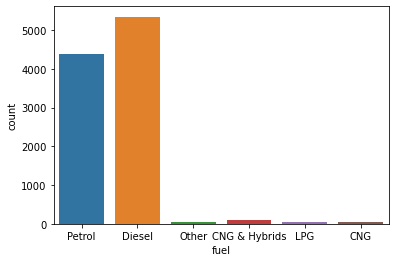

In [34]:
print(df['fuel'].value_counts())
sns.countplot(df['fuel'])

We can see that Diesel and Petrol are the maximum fuels used by cars, whereas CNG and LPG are the least used.

In [35]:
print(df['transmission'].value_counts())
sns.countplot(df['transmission'])

Manual       8598
Automatic    1402
Name: transmission, dtype: int64


<AxesSubplot:xlabel='transmission', ylabel='count'>

Most of the cars have manual transmission as the highest weightage

2017    1099
2016    1021
2018     983
2015     975
2012     844
2014     842
2013     802
2011     733
2019     642
2010     519
2009     366
2008     300
2007     207
2006     148
2020     132
2005     112
2004      71
2003      55
2002      45
2000      24
1999      24
2001      16
1997      11
2021      10
1998       9
1994       3
1996       3
1995       2
1983       1
1991       1
Name: year, dtype: int64


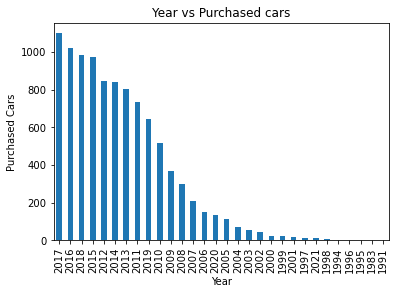

In [36]:
print(df['year'].value_counts())
purchased_car_per_year = df['year'].value_counts()
purchased_car_per_year.plot(kind='bar')
plt.xlabel("Year")
plt.ylabel("Purchased Cars")
plt.title("Year vs Purchased cars")
plt.show()

Maximum number of cars are bought in the year 2017 whereas minimum number of cars were brought in 1991 and 1983.

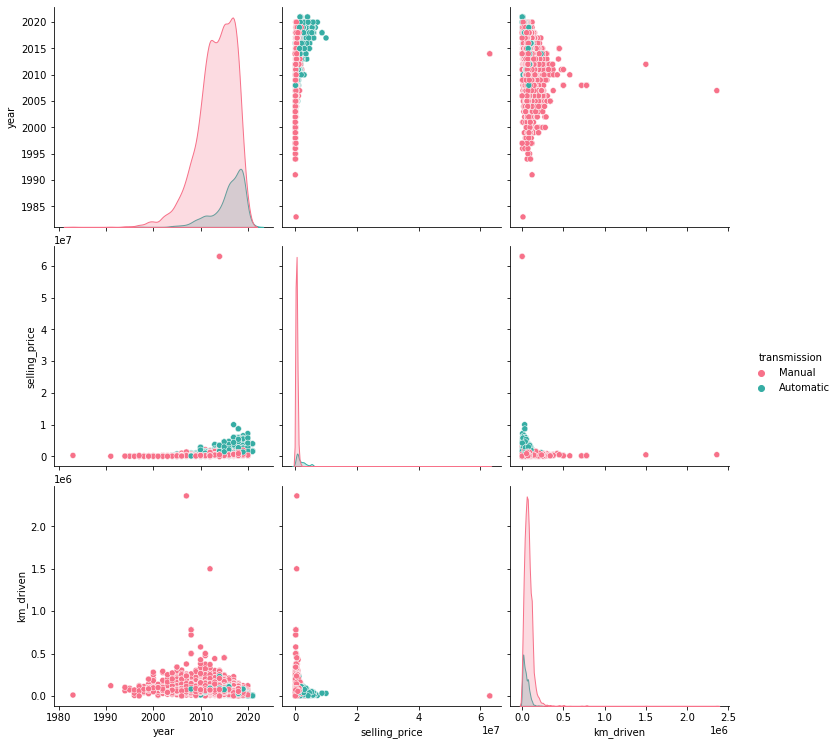

In [37]:
sns.pairplot(df,hue = 'transmission',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5) 
plt.show()

We can see that manual cars have higher price range than automatic type cars though the distribution were skewed to the right. We can also see the increase of cars between 2010 and 2020.

In [38]:
manual = df[df['transmission']=='Manual']
automatic = df[df['transmission']=='Automatic']

Manual type car


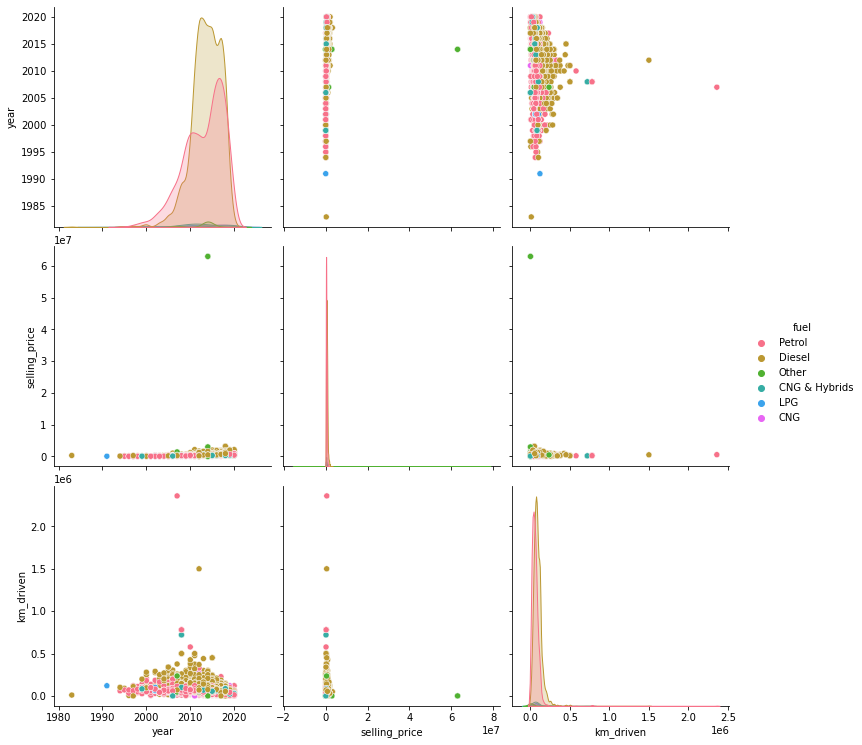

In [39]:
print('Manual type car')
sns.pairplot(manual,hue = 'fuel',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

Automatic type car


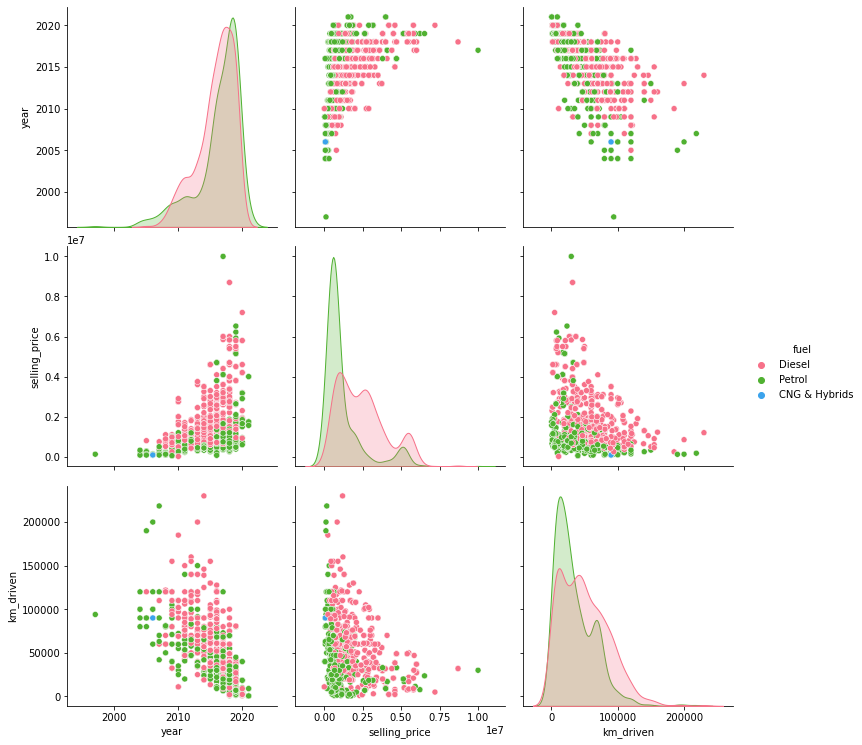

In [40]:
print('Automatic type car')
sns.pairplot(automatic,hue = 'fuel',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show()

We can see that the selling price of diesel type cars in both manual and automatic were more spread than diesel and other fuel hence getting higher average and range of selling price.

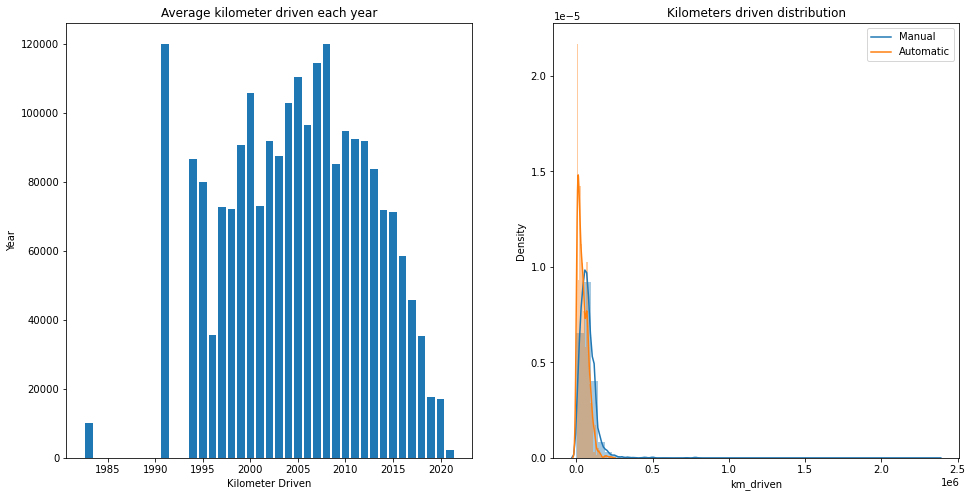

In [41]:
km_mean = df.groupby('year')['km_driven'].mean()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))

ax[0].bar(km_mean.index,km_mean)
sns.distplot(manual['km_driven'],ax=ax[1])
sns.distplot(automatic['km_driven'],ax=ax[1])

ax[0].set_title('Average kilometer driven each year')
ax[0].set_xlabel('Kilometer Driven')
ax[0].set_ylabel('Year')

ax[1].set_title('Kilometers driven distribution')
ax[1].legend(['Manual','Automatic'])

plt.show()

We can see that average kilometers driven rises up from 1995 until 2008 and linearly goes down until 2020. We can also see some outliers present in the distribution plot.

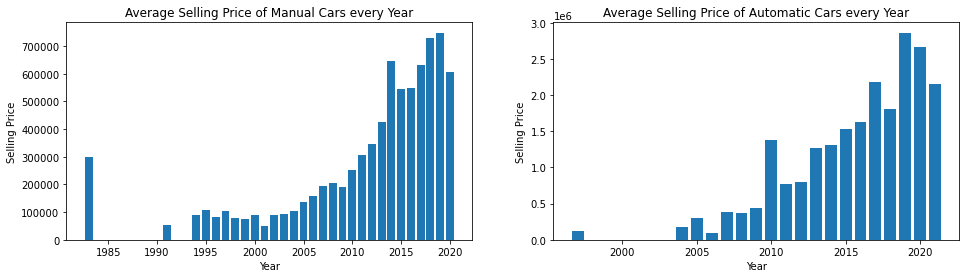

In [42]:
year_mean_manual = df[df['transmission']=='Manual'].groupby('year')['selling_price'].mean()
year_mean_automatic = df[df['transmission']=='Automatic'].groupby('year')['selling_price'].mean()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

ax[0].bar(year_mean_manual.index,year_mean_manual)
ax[1].bar(year_mean_automatic.index,year_mean_automatic)

ax[0].set_title('Average Selling Price of Manual Cars every Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Selling Price')

ax[1].set_title('Average Selling Price of Automatic Cars every Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Selling Price')

plt.show()

# Converting categorical data into numerical data

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col=['fuel','transmission'] 
for i in col:
    df[i] = le.fit_transform(df[i])

In [44]:
df.head()

name  year  selling_price  km_driven  fuel  transmission
0        Hyundai  2017       525000.0       2200     5             1
1        Hyundai  2013       595000.0      91500     2             1
2           Ford  2017       775000.0      36000     2             1
3          Honda  2015       400000.0      90000     2             1
4  Maruti Suzuki  2010       230000.0      40000     5             1

By using label encoder, we had converted object data into numerical data

## Multivariate Analysis

In [45]:
df.describe()    

year  selling_price     km_driven         fuel  transmission
count  10000.00000   1.000000e+04  1.000000e+04  10000.00000  10000.000000
mean    2013.69860   6.608371e+05  6.914651e+04      3.30960      0.859800
std        4.02124   1.204508e+06  5.868048e+04      1.51439      0.347212
min     1983.00000   0.000000e+00  0.000000e+00      0.00000      0.000000
25%     2011.00000   2.549990e+05  3.500000e+04      2.00000      1.000000
50%     2014.00000   4.500000e+05  6.000000e+04      2.00000      1.000000
75%     2017.00000   6.770000e+05  9.000000e+04      5.00000      1.000000
max     2021.00000   6.300000e+07  2.360457e+06      5.00000      1.000000

Observations:

1.There is not much difference between the mean and the median

2.The minimum value is 0 for all other columns.

3.The 75th percentile and max value difference for km_driven column is high and it is due to the presence of outliers.

In [46]:
corr=df.corr() 
corr

year  selling_price  km_driven      fuel  transmission
year           1.000000       0.278422  -0.391988 -0.050646     -0.234196
selling_price  0.278422       1.000000  -0.147619 -0.121624     -0.400351
km_driven     -0.391988      -0.147619   1.000000 -0.247807      0.182361
fuel          -0.050646      -0.121624  -0.247807  1.000000     -0.028709
transmission  -0.234196      -0.400351   0.182361 -0.028709      1.000000

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,linewidth=0.5,linecolor='black',fmt='.0%',cmap='rainbow',annot=True)
plt.show()

Observations:

1.There are more than 1 negative correlations present in the dataset

2.Highest positively correlated column has a value of 28%.

3.Highest negatively correlated column has a value of -40%

4.Positively correlated columns have a high impact with the target variable whereas negatively correlated columns have less or zero impact with the target variable.

Text(0.5, 1.0, 'Correlation with Target variable')

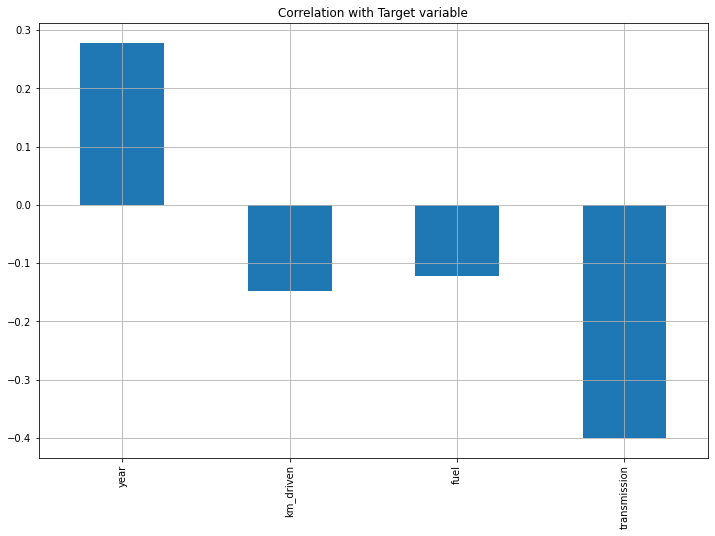

In [48]:
plt.figure(figsize=(12,8))
df.drop('selling_price',axis=1).corrwith(df['selling_price']).plot(kind='bar',grid=True)
plt.title('Correlation with Target variable')

We can see that year column is the only highly correlated column

In [49]:
df.drop(['name'],axis=1,inplace=True)

# Checking skewness

In [50]:
df.skew()

year             -0.970990
selling_price    28.995597
km_driven         9.944101
fuel              0.167063
transmission     -2.072925
dtype: float64

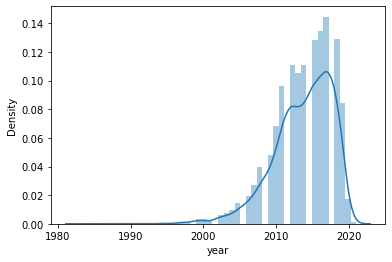

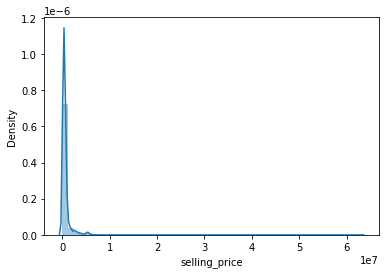

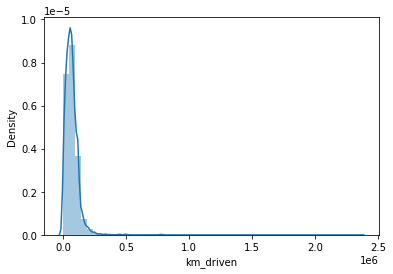

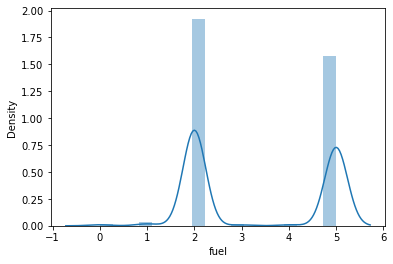

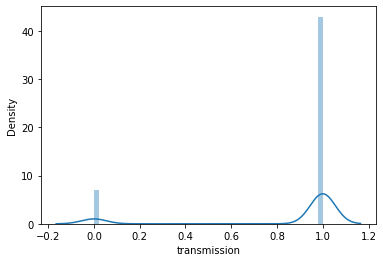

In [51]:
for col in df.describe().columns:
    sns.distplot(df[col])
    plt.show()

High skewness is present in selling_price and km_driven columns.

# Checking outliers

In [52]:
collist=df.columns.values 
ncol=20
nrows=20

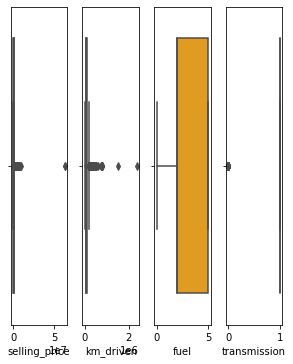

In [53]:
plt.figure(figsize=(ncol,5*ncol))
for i in range (1,len(collist)):
    plt.subplot(nrows,ncol,i+1)
    sns.boxplot(df[collist[i]],color='orange',orient='v')
    plt.tight_layout()

# Handling outliers by using z-score method

In [54]:
from scipy.stats import zscore
import numpy as np
z=np.abs(zscore(df))   
threshold=3    
np.where(z>3)

(array([   6,   13,   46,   53,  166,  173,  299,  311,  312,  321,  328,
         329,  335,  355,  377,  406,  413,  539,  551,  552,  568,  569,
         595,  617,  641,  682,  703,  705,  733,  766,  846,  899,  911,
         912,  928,  929,  955,  977, 1007, 1132, 1135, 1136, 1139, 1148,
        1170, 1177, 1186, 1288, 1316, 1371, 1384, 1385, 1401, 1410, 1423,
        1424, 1461, 1647, 1660, 1661, 1774, 1808, 1886, 1998, 1999, 2025,
        2045, 2071, 2078, 2091, 2092, 2097, 2110, 2111, 2116, 2129, 2130,
        2135, 2148, 2149, 2216, 2237, 2379, 2432, 2468, 2474, 2562, 2629,
        2710, 2723, 2724, 2775, 2810, 2815, 2858, 2871, 2872, 2882, 2972,
        2997, 3006, 3036, 3094, 3140, 3145, 3272, 3327, 3340, 3402, 3424,
        3579, 3584, 3631, 3644, 3645, 3664, 3677, 3678, 3726, 3805, 3818,
        3886, 3938, 3977, 3999, 4046, 4079, 4092, 4093, 4097, 4120, 4237,
        4240, 4310, 4378, 4409, 4422, 4423, 4486, 4508, 4517, 4530, 4531,
        4583, 4584, 4641, 4832, 4845, 

In [55]:
df_new=df[(z<3).all(axis=1)]
df_new

year  selling_price  km_driven  fuel  transmission
0     2017       525000.0       2200     5             1
1     2013       595000.0      91500     2             1
2     2017       775000.0      36000     2             1
3     2015       400000.0      90000     2             1
4     2010       230000.0      40000     5             1
...    ...            ...        ...   ...           ...
9995  2012       325000.0      65000     5             1
9996  2018       290000.0      85000     1             1
9997  2010       320000.0      72000     5             1
9998  2012       185000.0      70000     2             1
9999  2018       875000.0      53764     2             1

[9660 rows x 5 columns]

In [56]:
df.shape   

(10000, 5)

In [57]:
df_new.shape  

(9660, 5)

Nearly 300+ rows of data had outliers and they had been handled by using z-score method

# Percentage loss of data after removing outliers

In [58]:
percentage_loss=((340)/10000)*100 
print(percentage_loss)

3.4000000000000004


We can see that less number of data has been removed and it's not a big loss

# Preparing dataset for model training

In [59]:
df_x=df_new.drop('selling_price',axis=1)   
y=df_new['selling_price']    

In [60]:
df_x.head()

year  km_driven  fuel  transmission
0  2017       2200     5             1
1  2013      91500     2             1
2  2017      36000     2             1
3  2015      90000     2             1
4  2010      40000     5             1

In [61]:
y.head()

0    525000.0
1    595000.0
2    775000.0
3    400000.0
4    230000.0
Name: selling_price, dtype: float64

# Treating skewness

In [62]:
for col in df_x.skew().index:
    if col in df_x.describe().columns:
        if df_x[col].skew()>0.55:
            df_x[col]=np.sqrt(df_x[col])
        if df_x[col].skew()<-0.55:
            df_x[col]=np.sqrt(df_x[col])  

In [63]:
df_x.skew()   

year           -0.656801
km_driven      -0.173734
fuel            0.156582
transmission   -2.214140
dtype: float64

We can see that skewness has been treated and we can proceed further model building process

# Scaling

In [64]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=sc.fit_transform(df_x)
x=pd.DataFrame(x,columns=df_x.columns)
x

year  km_driven      fuel  transmission
0     0.858876  -2.329023  1.110111       0.38482
1    -0.215883   0.690959 -0.870253       0.38482
2     0.858876  -0.641323 -0.870253       0.38482
3     0.321630   0.661541 -0.870253       0.38482
4    -1.022654  -0.520052  1.110111       0.38482
...        ...        ...       ...           ...
9655 -0.484740   0.129245  1.110111       0.38482
9656  1.127400   0.561668 -1.530374       0.38482
9657 -1.022654   0.287309  1.110111       0.38482
9658 -0.484740   0.242963 -0.870253       0.38482
9659  1.127400  -0.143471 -0.870253       0.38482

[9660 rows x 4 columns]

# Model Building

In [65]:
for i in range(42,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=i)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print('At random state',i,',the model performs well')
        print('Training r2_score is: ',r2_score(y_train,pred_train)*100)
        print('Testing r2_score is: ',r2_score(y_test,pred_test)*100)

At random state 48 ,the model performs well
Training r2_score is:  49.81505489460692
Testing r2_score is:  49.78050062810894
At random state 73 ,the model performs well
Training r2_score is:  49.81662674234254
Testing r2_score is:  49.75466781460837


We can see that at random_state=48, the best r2_score is obtained so that we can create our train_test_split with this random state.

In [66]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=48,test_size=.20)

# Finding the best model

In [67]:
LR=LinearRegression()
l=Lasso()
en=ElasticNet()
rd=Ridge()
dtr=DecisionTreeRegressor()
knr=KNeighborsRegressor()
rf=RandomForestRegressor()
ab=AdaBoostRegressor()
gb=GradientBoostingRegressor()

In [68]:
models= []
models.append(('Linear Regression',LR))
models.append(('Lasso Regression',l))
models.append(('Elastic Net Regression',en))
models.append(('Ridge Regression',rd))
models.append(('Decision Tree Regressor',dtr))
models.append(('KNeighbors Regressor',knr))
models.append(('RandomForestRegressor',rf))
models.append(('AdaBoostRegressor',ab))
models.append(('GradientBoostingRegressor',gb))

In [69]:
Model=[]
score=[]
cvs=[]
sd=[]
mae=[]
mse=[]
rmse=[]
for name,model in models:
    print('******************************',name,'***************************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=r2_score(y_test,pre)
    print('r2_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='r2').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    std=cross_val_score(model,x,y,cv=5,scoring='r2').std()
    print('Standard Deviation: ',std)
    sd.append(std)
    print('\n')
    MAE=mean_absolute_error(y_test,pre)
    print('Mean Absolute Error: ',MAE)
    mae.append(MAE)
    print('\n')
    MSE=mean_squared_error(y_test,pre)
    print('Mean Squared Error: ',MSE)
    mse.append(MSE)
    print('\n')
    RMSE=np.sqrt(mean_squared_error(y_test,pre))
    print('Root Mean Squared Error: ',RMSE)
    rmse.append(RMSE)
    print('\n\n')

****************************** Linear Regression ***************************


LinearRegression()


r2_score:  0.49780500628108937


cross_val_score:  0.49634394859423203


Standard Deviation:  0.016118488875161353


Mean Absolute Error:  245143.39331608513


Mean Squared Error:  159654922494.05557


Root Mean Squared Error:  399568.4202912632



****************************** Lasso Regression ***************************


Lasso()


r2_score:  0.49780509253388605


cross_val_score:  0.4963439420374778


Standard Deviation:  0.01611829795047155


Mean Absolute Error:  245142.90969085626


Mean Squared Error:  159654895073.06622


Root Mean Squared Error:  399568.3859780028



****************************** Elastic Net Regression ***************************


ElasticNet()


r2_score:  0.45587343179152995


cross_val_score:  0.45318972356504583


Standard Deviation:  0.01535342392589888


Mean Absolute Error:  234774.44047653952


Mean Squared Error:  172985565688.26358


Root Mean Square

In [70]:
result=pd.DataFrame({'Model':Model, 'r2_score': score, 'Cross_val_score':cvs, 'Standard_deviation':sd,
                    'Mean_absolute_error':mae, 'Mean_squared_error':mse, 'Root_Mean_Squared_error':rmse})
result

Model   r2_score  Cross_val_score  Standard_deviation  \
0          Linear Regression  49.780501        49.634395            0.016118   
1           Lasso Regression  49.780509        49.634394            0.016118   
2     Elastic Net Regression  45.587343        45.318972            0.015353   
3           Ridge Regression  49.780536        49.634433            0.016118   
4    Decision Tree Regressor  73.953042        74.150242            0.077926   
5       KNeighbors Regressor  74.761909        71.831772            0.037407   
6      RandomForestRegressor  77.989965        77.102421            0.053776   
7          AdaBoostRegressor  51.675815        48.243361            0.051122   
8  GradientBoostingRegressor  70.247814        68.762668            0.015559   

   Mean_absolute_error  Mean_squared_error  Root_Mean_Squared_error  
0        245143.393316        1.596549e+11            399568.420291  
1        245142.909691        1.596549e+11            399568.385978  
2        234774.440477        1.729856e+11            415915.334760  
3        245134.259261        1.596548e+11            399568.281071  
4        144285.246136        8.280698e+10            287762.018190  
5        152245.250104        8.023548e+10            283258.675692  
6        142041.655199        6.997303e+10            264524.154290  
7        248386.452195        1.536294e+11            391955.928264  
8        179594.093435        9.458643e+10            307549.063969

We can see that Random Forest Regressor and KNeighbors Regressor are performing well compared to other algorithms. Now we will try Hyperparameter Tuning to find out the best parameters and try to increase the scores.

# Hyperparameter Tuning


## KNeighbors Regressor

In [77]:
parameters={'n_neighbors':(1,10),'weights':['uniform','distance'],'algorithm':['auto','ball_tree','brute','kd_tree']}

In [78]:
from sklearn.model_selection import GridSearchCV
knr=KNeighborsRegressor()
grid=GridSearchCV(knr,parameters,cv=5,scoring='r2')
grid.fit(x_train,y_train)
print(grid.best_params_)  
print(grid.best_score_) 

{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}
0.7451186630235311


In [79]:
knr=KNeighborsRegressor(algorithm='brute', n_neighbors=10, weights='distance')
knr.fit(x_train,y_train)
pred=knr.predict(x_test)
print('Final r2_score after tuning is: ',r2_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(knr,x,y,cv=5,scoring='r2').mean()*100)
print('Standard deviation: ',cross_val_score(knr,x,y,cv=5,scoring='r2').std())
print('\n')
print('Mean absolute error: ',mean_absolute_error(y_test,pred))
print('Mean squared error: ',mean_squared_error(y_test,pred))
print('Root Mean squared error: ',np.sqrt(mean_squared_error(y_test,pred)))

Final r2_score after tuning is:  77.66397076547491
Cross validation score:  76.63929919814726
Standard deviation:  0.05760230307407942


Mean absolute error:  139198.6305152985
Mean squared error:  71009409907.79892
Root Mean squared error:  266475.90868181485


# Finalizing the model

In [80]:
rf_prediction=RF.predict(x)
print('Predictions of Random Forest Regressor: ',rf_prediction)

Predictions of Random Forest Regressor:  [523000.         644522.88752914 760124.50877554 ... 320000.
 276868.90269236 896053.87848263]


In [81]:
predictions=pd.DataFrame({'Original_price':y, 'Predicted_price':rf_prediction})
predictions

Original_price  Predicted_price
0           525000.0    523000.000000
1           595000.0    644522.887529
2           775000.0    760124.508776
3           400000.0    592402.068286
4           230000.0    211955.678041
...              ...              ...
9995        325000.0    269123.641775
9996        290000.0    305584.444444
9997        320000.0    320000.000000
9998        185000.0    276868.902692
9999        875000.0    896053.878483

[9660 rows x 2 columns]

### Saving the model

In [82]:
import pickle
filename='Car_Price_Project.pkl'  
pickle.dump(RF,open(filename,'wb'))

In [83]:
results=pd.DataFrame(rf_prediction)
results.to_csv('Car_Price_Prediction_Results.csv')